In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import display

### Helper libraries 
`visuals`
The visuals class is designed for visualizing matrices through plotting and animation. It supports reshaping data and generating snapshots or animations of matrix time series.
Methods:
* reshape_data(matrix, num_rows, num_cols, num_snapshots): Reshapes the input matrix into a 3D array suitable for visualization.
* plotSnap(snapshot_idx, type): Plots a single snapshot of the matrix at the specified index.
* flowAnimation(frames, type): Creates an animation showing the flow of matrix snapshots over time.

`svd`
The svd class provides functionalities related to Singular Value Decomposition (SVD) of matrices. It includes methods for decomposition, truncation, and energy analysis.
* decompose(): Returns the matrices U, S, and Vt from SVD.
* truncateSVD(k): Returns the truncated SVD matrices using the top k singular values.
* firstKModes(k): Reconstructs the matrix using the first k modes.
* thresholdEnergyMode(thresholdEnergy): Determines the number of modes needed to reach a specified cumulative energy threshold.
* plotCumEnergy(): Plots the cumulative energy of the singular values.
* error(k): Calculates the Frobenius norm of the error between the original matrix and its k-mode approximation.

`LinReg`
The LinReg class performs linear regression on matrix data, specifically for eigenvalue analysis.
* self.A: linear model
* plotEigen(): Plots the eigenvalues of the matrix A in the complex plane.

In [26]:
class visuals:

    def __init__(self, Matrix, rows, cols):
        self.matrices = self.reshape_data(Matrix, rows, cols, Matrix.shape[1])

    def reshape_data(self, matrix, num_rows, num_cols, num_snapshots):
        reshaped = np.zeros((num_cols, num_rows, num_snapshots))
        for i in range(num_snapshots):
            reshaped[:, :, i] = matrix[:, i].reshape((num_rows, num_cols)).T
        return reshaped

    def plotSnap(self, snapshot_idx, type):
        matrices = self.matrices
        plt.figure(figsize=(6, 4))
        plt.imshow(matrices[:, :, snapshot_idx], cmap="nipy_spectral_r")
        plt.title(f'Time Snapshot {snapshot_idx}of {type} Matrix')
        plt.colorbar()
        
        # Create a circle patch
        circle = plt.Circle((50, 100), 25, color='black', fill=True)
        plt.gca().add_patch(circle)  # Add the circle to the current axis
        plt.show()

    def flowAnimation(self, frames, type):
        matrices = self.matrices
        fig, ax = plt.subplots(figsize=(6, 4))
        screen = ax.imshow(matrices[:, :, 0], cmap="nipy_spectral_r")
        fig.colorbar(screen, ax=ax)
        
        # Create a circle patch
        circle = plt.Circle((50, 100), 25, color='black', fill=True)
        ax.add_patch(circle)  # Add the circle to the axes
        
        def update(frame):
            screen.set_data(matrices[:, :, frame])
            ax.set_title(f'Time Snapshot {frame} of the {type} Matrix')
            return screen, circle  # Return the circle to ensure it is drawn
        
        ani = FuncAnimation(fig, update, frames=frames, repeat=True)
        plt.close(fig)
        return HTML(ani.to_jshtml())

class svd:
    def __init__(self, Matrix, rows, cols) -> None:
        self.U, self.S, self.Vt = np.linalg.svd(Matrix, full_matrices=False)
        self.matrix, self.rows, self.cols = Matrix, rows, cols
        self.cumEnergy = np.cumsum(self.S**2) / np.sum(self.S**2)
    
    def decompose(self):
        return self.U, self.S, self.Vt

    def truncateSVD(self, k):
        _U, _S, _Vt = self.U, self.S, self.Vt
        return _U[:, :k], np.diag(_S[:k]), _Vt[:k, :]
    
    def firstKModes(self, k):
        ub, sb, vtb = self.truncateSVD(k)
        return ub @ sb @ vtb
        
    def thresholdEnergyMode(self, thresholdEnergy):
        _cumEnergy = self.cumEnergy
        return np.searchsorted(_cumEnergy, thresholdEnergy) + 1

    def plotCumEnergy(self):
        _cumEnergy = self.cumEnergy
        plt.figure(figsize=(6, 4))
        plt.plot(_cumEnergy, label='Cumulative Energy of the Flow', color='blue')
        plt.legend()
        plt.show()
    
    def error(self, k):
        original_matrix = self.matrix
        reconstructed_matrix = self.firstKModes(k)
        return np.linalg.norm(original_matrix - reconstructed_matrix, 'fro')**2



class LinReg:
    def __init__(self, sb, vtb, m):
        w = np.dot(sb, vtb)
        W = w[:, :m-1]
        W_prime = w[:, 1:m]
        W_pseudo_inv = np.linalg.pinv(W)
        self.A = W_prime @ W_pseudo_inv
        self.w = w
    
    def plotEigen(self):
        eigenvalues = np.linalg.eigvals(self.A)
        plt.figure(figsize=(6, 6))
        plt.scatter(eigenvalues.real, eigenvalues.imag, color='blue', marker='o')
        plt.axhline(0, color='black', linestyle='--')
        plt.axvline(0, color='black', linestyle='--')
        plt.xlabel('Real Part')
        plt.ylabel('Imaginary Part')
        plt.title('Eigenvalues of Matrix A')
        plt.grid(True)
        plt.show()


### Importing dataset 

In [4]:
data = scipy.io.loadmat('./Dataset/Assignment1Dataset.mat')
UALL = data["UALL"]
VALL = data["VALL"]

### Initalising datasset variables
* nrows: rows of a perticular snapshot
* ncols: columns of a perticular snapshot
* num_snapshots: total snaps
* magnitude: resultant vector magnitude

In [5]:
nrows, ncols, num_snapshots = 449, 199, 151
magnitude = np.sqrt(UALL**2 + VALL**2)

### Visual representation of dataset

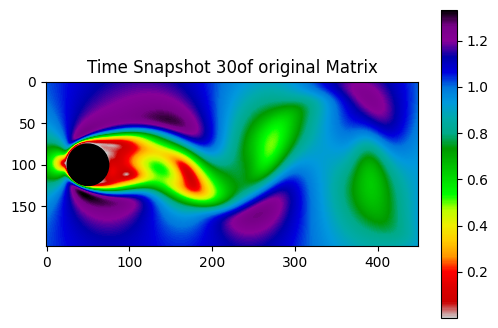

In [27]:
# original dataset visualisation
viewMagnitude = visuals(magnitude, nrows, ncols)

# video of first n snaps for recuding memory consumption
flowAni = viewMagnitude.flowAnimation(50, "Original")
display(flowAni)

# plot of ith snapshot
viewMagnitude.plotSnap(30, "original")


## Question 1

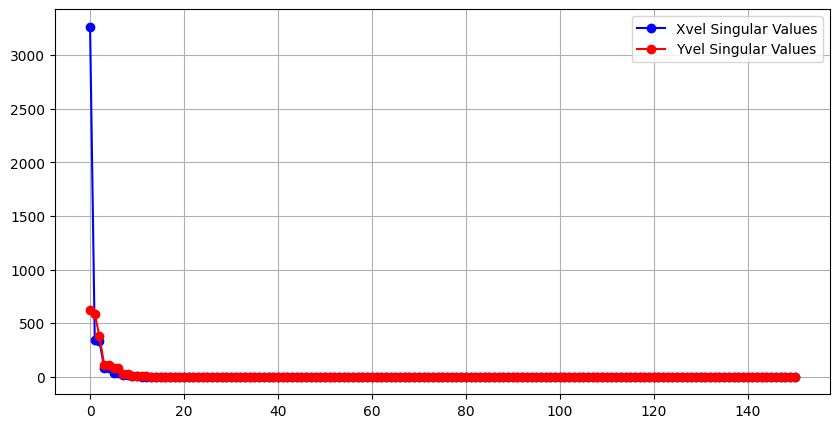

In [28]:
# svd for the U_all and V_all
U_UALL, S_UALL, Vt_UALL = np.linalg.svd(UALL, full_matrices=False)
U_VALL, S_VALL, Vt_VALL = np.linalg.svd(VALL, full_matrices=False)

plt.figure(figsize=(10, 5))
plt.plot(S_UALL, 'bo-', label='Xvel Singular Values')
# plt.plot(S_VALL, 'ro-', label='Yvel Singular Values')
plt.grid(True)
plt.legend()
plt.show()


## Question 2

for Energy threshold 90% Truncation r = 1, error = 257504.42347509525
for Energy threshold 99% Truncation r = 3, error = 31724.196626600293
for Energy threshold 99.99% Truncation r = 9, error = 367.3596781330071


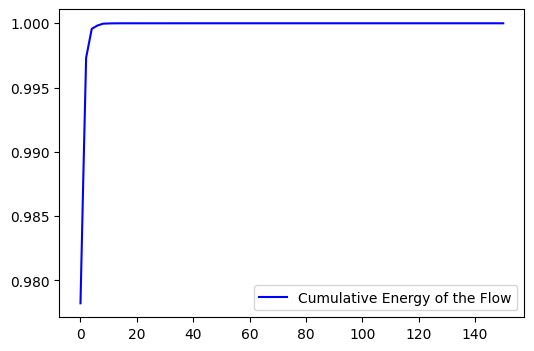

In [29]:
flow_svd = svd(magnitude, nrows*ncols, num_snapshots)

# truncation values r that captures threshold energy of flow
r90, r99, r9999 = flow_svd.thresholdEnergyMode(0.9), flow_svd.thresholdEnergyMode(0.99), flow_svd.thresholdEnergyMode(0.9999)
error90, error99, error9999 = flow_svd.error(r90), flow_svd.error(r99), flow_svd.error(r9999)

print(f'for Energy threshold 90% Truncation r = {r90}, error = {error90}')
print(f'for Energy threshold 99% Truncation r = {r99}, error = {error99}')
print(f'for Energy threshold 99.99% Truncation r = {r9999}, error = {error9999}')

# cummutaive energy curve
r = flow_svd.plotCumEnergy()

# displaying the recontructed matrix by truncation of real matrix at r = 99
truncatedVisuals99 = visuals(flow_svd.firstKModes(r99), nrows, ncols)
display(truncatedVisuals99.flowAnimation(50, 'Truncated 99% Energy'))

## Question 3

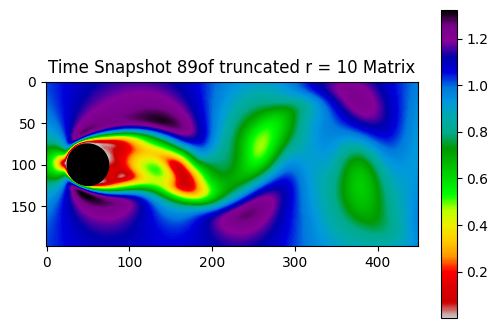

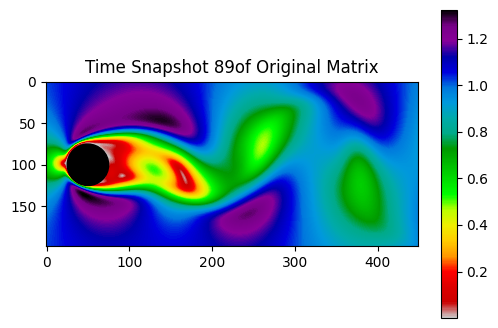

In [30]:
# considering only first 10 modes and reconstructing the original matrix 
lowRankFlow = visuals(flow_svd.firstKModes(10), nrows, ncols)

# comparision of 89 snapshort of orginal vs reconstructed
lowRankFlow.plotSnap(89, "truncated r = 10")
viewMagnitude.plotSnap(89, "Original")

## Question 4

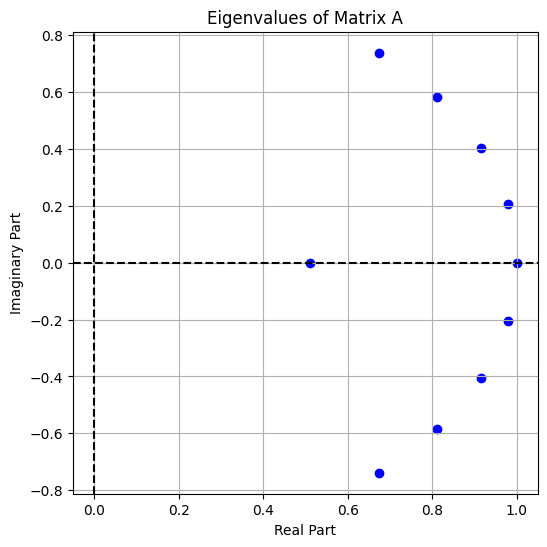

In [33]:
# truncating the svd till 10 modes
U_truncated, S_truncated, Vt_truncated= flow_svd.truncateSVD(10)

# Compute matrix A using linear regression
linreg = LinReg(S_truncated, Vt_truncated, 150)

# ploting the eigen values of the linear regression matrix
linreg.plotEigen()

## Question 5

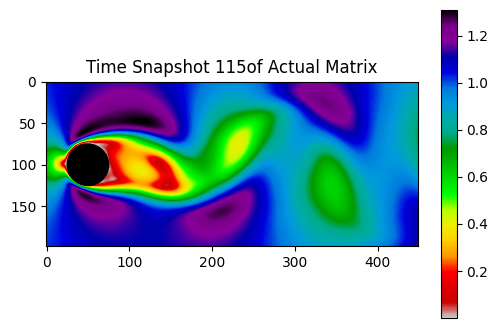

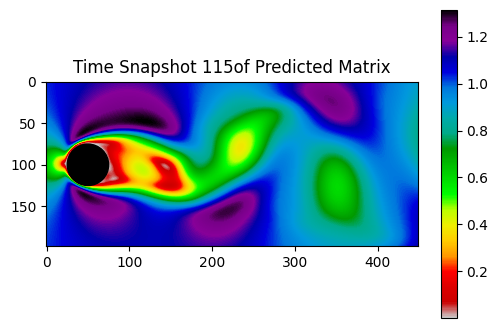

In [40]:
# linear regression modal
A = linreg.A
SVt_truncated = S_truncated @ Vt_truncated

# Initialize omega
omega = np.zeros((SVt_truncated.shape[0], num_snapshots))
omega[:, 0] = SVt_truncated[:, 0]

# Predict future snapshots
for i in range(1, num_snapshots):
    omega[:, i] = np.dot(np.linalg.matrix_power(A, i-1), omega[:, i-1])

# Reconstruct the flow fields
actualVisuals = visuals(U_truncated @ SVt_truncated, nrows, ncols)
predictedVisuals = visuals(U_truncated @ omega, nrows, ncols)


# Plot snapshots
nthSnapDiff = 115
actualVisuals.plotSnap(nthSnapDiff, "Actual")
predictedVisuals.plotSnap(nthSnapDiff, "Predicted")